In [ ]:
# Note: Please follow to the About Fastai section in the README to update the fastai accordingly

In [1]:
from fastai.tabular.all import *

# for feature generation and plotting
from cryspnet.utils import *
# for accessing some pre-defined constant
from cryspnet.config import *

import pandas as pd
import numpy as np

In [ ]:
@patch
def setups(self:FillMissing, dsets):
    missing = pd.isnull(dsets.conts).any()
    store_attr(but='dsets', na_dict={n:self.fill_strategy(dsets[n], self.fill_vals[n]) for n in missing[missing].keys()})
    self.fill_strategy = self.fill_strategy.__name__

In [2]:
df = pd.read_csv("../demo/demo_train.csv")

In [3]:
df.head()

,formula,Space Group,Bravais,a,b,c,alpha,beta,gamma
0,C4Hf1Ta2U1,225,cubic (F),4.615,4.615,4.615,90.0,90.0,90.0
1,Co1Sb1Ta1,216,cubic (F),5.883,5.883,5.883,90.0,90.0,90.0
2,Ge0.8Sb0.133Se0.133Te0.867,225,cubic (F),5.951,5.951,5.951,90.0,90.0,90.0
3,C1Ni1,225,cubic (F),4.077,4.077,4.077,90.0,90.0,90.0
4,Ir7Mg44,216,cubic (F),20.097,20.097,20.097,90.0,90.0,90.0


# Generate features with matminer

In [4]:
fgenerator = FeatureGenerator()

In [5]:
df_predictors = fgenerator.generate(df)

StrToComposition:   0%|          | 0/280 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/280 [00:00<?, ?it/s]

In [6]:
df_predictors.head()

,formula,Space Group,Bravais,a,b,c,alpha,beta,gamma,composition,...,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr,NComp
0,C4Hf1Ta2U1,225,cubic (F),4.615,4.615,4.615,90.0,90.0,90.0,"(C, Hf, Ta, U)",...,0,0.0,0,0,0,0,0,0,0,4
1,Co1Sb1Ta1,216,cubic (F),5.883,5.883,5.883,90.0,90.0,90.0,"(Co, Sb, Ta)",...,0,0.0,0,0,0,0,0,0,0,3
2,Ge0.8Sb0.133Se0.133Te0.867,225,cubic (F),5.951,5.951,5.951,90.0,90.0,90.0,"(Ge, Sb, Se, Te)",...,0,0.0,0,0,0,0,0,0,0,4
3,C1Ni1,225,cubic (F),4.077,4.077,4.077,90.0,90.0,90.0,"(C, Ni)",...,0,0.0,0,0,0,0,0,0,0,2
4,Ir7Mg44,216,cubic (F),20.097,20.097,20.097,90.0,90.0,90.0,"(Ir, Mg)",...,0,0.0,0,0,0,0,0,0,0,2


# train models for lattice parameters

In [7]:
def initializer(df, dep_vars, cont_names=[], cat_names=[], classes=None, p=0.1, bs=32):

    # split train and validation set and do oversampling if enabled
    val_idx= np.random.choice(df.index, int(len(df)*p), replace=False)    
    splits = IndexSplitter(val_idx)(df.index)
    
    y_range = ( group[dep_vars].min(axis=0).values, group[dep_vars].max(axis=0).values )
    y_range = (torch.FloatTensor(y_range[0]).cuda(), torch.FloatTensor(y_range[1]).cuda())
                
    # create datasets
    trn_cols = list(cont_names) + list(cat_names) + dep_vars
    
    to = TabularPandas(df[trn_cols], procs=[Categorify, FillMissing, Normalize],
                   cat_names=cat_names,
                   cont_names=cont_names,
                   y_names=dep_vars,
                   splits=splits)
    
    # turn it into dataloader
    dls = to.dataloaders(bs=bs)
    
    # use the dataset to create the corresponding tabular learner
    # config allow us to tune the actual architecture
    # metrics are for evaluation
    config = tabular_config(ps=[0.0]+[0.1]*4, bn_cont=False, bn_final=True) # add drop out layer
    
    learn = tabular_learner(
        dls,
        layers=[256, 256, 256, 256], # set layer dimension
        config=config,
        y_range=y_range
    )
    
    learn.lattice_params = dep_vars
    
    return learn

In [8]:
groups = df_predictors.groupby("Bravais")

In [9]:
learner_folder = Path(LEARNER)
learner_folder.mkdir(exist_ok=True)
# metal or oxide subset is similar but just replace whole with metal or oxide
lattice_folder = learner_folder / LATTICE_PARAM_MODELS_FOLDER
lattice_folder.mkdir(exist_ok=True)

In [23]:
lattice_folder

Path('/home/aurora/cryspnet/cryspnet/learner/LatticeParam')

Training a model on cubic (F) subset


SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=1.5848931980144698e-06)


epoch,train_loss,valid_loss,time
0,1.912622,0.366807,00:00
1,1.787598,0.228077,00:00
2,2.023282,0.164617,00:00
3,2.002596,0.255417,00:00
4,1.727603,0.879861,00:00
5,1.671039,0.305517,00:00
6,1.811054,0.021392,00:00
7,1.625645,0.253779,00:00
8,1.593699,0.255969,00:00
9,1.598020,0.242607,00:00


epoch,train_loss,valid_loss,time
0,1.828837,0.117928,00:00
1,1.283267,0.004269,00:00
2,1.388976,0.021257,00:00
3,1.867180,0.248613,00:00
4,2.308109,0.919808,00:00
5,2.362615,0.005235,00:00
6,2.444520,0.097636,00:00
7,2.227725,0.102479,00:00
8,1.982717,0.108526,00:00
9,1.784372,0.145538,00:00


Training a model on cubic (I) subset


SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=2.75422871709452e-06)


epoch,train_loss,valid_loss,time
0,0.932597,9141472.000000,00:00
1,1.271557,9709206528.000000,00:00
2,1.471061,161193885696.000000,00:00
3,1.341373,328788180992.000000,00:00
4,1.501731,205282476032.000000,00:00
5,1.440548,83285581824.000000,00:00
6,1.546162,177705009152.000000,00:00
7,1.503810,1000034533376.000000,00:00
8,1.402565,757009743872.000000,00:00
9,1.443407,4747922767872.000000,00:00


epoch,train_loss,valid_loss,time
0,1.654971,11219946700800.000000,00:00
1,1.454450,2962428788736.000000,00:00
2,2.096967,2594094710784.000000,00:00
3,2.226709,21383155286016.000000,00:00
4,2.036036,15108960944128.000000,00:00
5,1.716429,9574627147776.000000,00:00
6,1.706619,5414997458944.000000,00:00
7,1.530696,2051187933184.000000,00:00
8,1.351661,48294883328.000000,00:00
9,1.265504,1433197477888.000000,00:00


Training a model on cubic (P) subset


None


epoch,train_loss,valid_loss,time
0,1.007733,79347000.000000,00:00
1,1.319393,214361040.000000,00:00
2,1.561849,93098752.000000,00:00
3,1.452158,6048222208.000000,00:00
4,1.320970,172666256.000000,00:00
5,1.220835,94010720.000000,00:00
6,1.681596,119758952.000000,00:00
7,1.620422,49756954624.000000,00:00
8,1.486178,263829438464.000000,00:00
9,1.375753,1289002024960.000000,00:00


epoch,train_loss,valid_loss,time
0,0.875563,3414216146944.000000,00:00
1,1.138141,3431487766528.000000,00:00
2,1.368219,2206371676160.000000,00:00
3,1.988409,6533284888576.000000,00:00
4,1.971271,8815071199232.000000,00:00
5,1.808235,9170491277312.000000,00:00
6,1.689754,10260634927104.000000,00:00
7,1.603186,9938198855680.000000,00:00
8,1.498515,8740590321664.000000,00:00
9,1.379941,4550091079680.000000,00:00


Training a model on hexagonal (P) subset


SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=3.981071586167673e-06)


epoch,train_loss,valid_loss,time
0,1.335558,2475037184.000000,00:00
1,1.499586,312274780160.000000,00:00
2,1.577109,2614483222528.000000,00:00
3,1.496062,5915260485632.000000,00:00
4,1.450684,21522882232320.000000,00:00
5,1.461985,17851725381632.000000,00:00
6,1.434893,14932966899712.000000,00:00
7,1.508671,14892580995072.000000,00:00
8,1.436799,25110765371392.000000,00:00
9,1.418519,65760793722880.000000,00:00


epoch,train_loss,valid_loss,time
0,1.128855,89724349841408.000000,00:00
1,1.408222,162128019324928.000000,00:00
2,1.271256,937883217166336.000000,00:00
3,1.317388,1649378708160512.000000,00:00
4,1.599592,490756821221376.000000,00:00
5,1.566151,1433098516430848.000000,00:00
6,1.540494,871566506196992.000000,00:00
7,1.416516,1069146074775552.000000,00:00
8,1.324589,1095401344073728.000000,00:00
9,1.372622,1146010017464320.000000,00:00


Training a model on monoclinic (C) subset


SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=6.309573450380412e-07)


epoch,train_loss,valid_loss,time
0,1.316510,18685938.000000,00:00
1,1.360320,2861904384.000000,00:00
2,1.333202,24899612672.000000,00:00
3,1.408690,36063297536.000000,00:00
4,1.587586,86259892224.000000,00:00
5,1.522458,56303673344.000000,00:00
6,1.438125,430384480256.000000,00:00
7,1.343612,552628912128.000000,00:00
8,1.287499,1708845039616.000000,00:00
9,1.193941,5164077940736.000000,00:00


epoch,train_loss,valid_loss,time
0,1.181477,12861944365056.000000,00:00
1,1.289376,19296524697600.000000,00:00
2,1.246056,32923990360064.000000,00:00
3,1.298199,32985917161472.000000,00:00
4,1.267466,18170070958080.000000,00:00
5,1.175752,29249733918720.000000,00:00
6,1.189612,18650589298688.000000,00:00
7,1.190903,18878444863488.000000,00:00
8,1.161284,18165792768000.000000,00:00
9,1.167104,19863231791104.000000,00:00


Training a model on monoclinic (P) subset


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)


epoch,train_loss,valid_loss,time
0,1.256749,7914462208.000000,00:00
1,1.244942,163305193472.000000,00:00
2,1.496683,382952669184.000000,00:00
3,1.758387,278756294656.000000,00:00
4,1.887250,2337518649344.000000,00:00
5,1.922783,337286660096.000000,00:00
6,1.908648,604575694848.000000,00:00
7,1.777635,1911244455936.000000,00:00
8,1.664434,1236346732544.000000,00:00
9,1.616411,2418720374784.000000,00:00


epoch,train_loss,valid_loss,time
0,1.317908,2517661122560.000000,00:00
1,1.201846,37840800972800.000000,00:00
2,1.460335,211056118988800.000000,00:00
3,1.725950,126409326460928.000000,00:00
4,1.644085,188988342140928.000000,00:00
5,1.494613,22360199528448.000000,00:00
6,1.407982,12474017382400.000000,00:00
7,1.430053,7056575692800.000000,00:00
8,1.345080,13733411684352.000000,00:00
9,1.268597,6787110535168.000000,00:00


Training a model on orthorhombic (C) subset


SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=7.585775847473997e-07)


epoch,train_loss,valid_loss,time
0,1.419497,127702328.000000,00:00
1,1.295526,913073536.000000,00:00
2,1.585793,227773743104.000000,00:00
3,1.596988,438982017024.000000,00:00
4,1.574441,303361425408.000000,00:00
5,1.486181,633328959488.000000,00:00
6,1.480656,625610719232.000000,00:00
7,1.504922,3234499133440.000000,00:00
8,1.415825,8952034099200.000000,00:00
9,1.346209,23671158603776.000000,00:00


epoch,train_loss,valid_loss,time
0,0.944571,30088225619968.000000,00:00
1,1.115513,247464187658240.000000,00:00
2,1.282184,294916546625536.000000,00:00
3,1.450889,146225500258304.000000,00:00
4,1.573781,466563303997440.000000,00:00
5,1.603331,219130959495168.000000,00:00
6,1.723075,153715252133888.000000,00:00
7,1.663805,31224986861568.000000,00:00
8,1.575078,48798290149376.000000,00:00
9,1.512826,64095298519040.000000,00:00


Training a model on orthorhombic (F) subset


SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=1.3182567499825382e-06)


epoch,train_loss,valid_loss,time
0,1.015260,422213120.000000,00:00
1,1.196321,7083173888.000000,00:00
2,1.269997,115116130304.000000,00:00
3,1.318518,63662776320.000000,00:00
4,1.331195,103252361216.000000,00:00
5,1.325198,378936459264.000000,00:00
6,1.365826,283250327552.000000,00:00
7,1.307580,506516799488.000000,00:00
8,1.304165,2497134460928.000000,00:00
9,1.259687,7610906443776.000000,00:00


epoch,train_loss,valid_loss,time
0,1.002908,9079429791744.000000,00:00
1,1.171969,37379171680256.000000,00:00
2,1.668586,3543909007360.000000,00:00
3,1.578226,3475832832000.000000,00:00
4,1.456497,37322947035136.000000,00:00
5,1.581464,32301675184128.000000,00:00
6,1.493817,16453096964096.000000,00:00
7,1.391998,20781413171200.000000,00:00
8,1.310008,19108150116352.000000,00:00
9,1.240040,15039589253120.000000,00:00


Training a model on orthorhombic (I) subset


SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=1.3182567499825382e-06)


epoch,train_loss,valid_loss,time
0,1.318513,968487296.000000,00:00
1,1.719639,2452402176.000000,00:00
2,1.677008,4677797376.000000,00:00
3,1.633440,38431113216.000000,00:00
4,1.603999,44787531776.000000,00:00
5,1.595591,256153796608.000000,00:00
6,1.480307,312632967168.000000,00:00
7,1.420110,993333215232.000000,00:00
8,1.395464,1187970809856.000000,00:00
9,1.405874,1688678170624.000000,00:00


epoch,train_loss,valid_loss,time
0,1.090684,3310159134720.000000,00:00
1,1.326432,12488531771392.000000,00:00
2,1.622458,3634450399232.000000,00:00
3,1.579048,3698170789888.000000,00:00
4,1.516072,17752974688256.000000,00:00
5,1.594523,26573159792640.000000,00:00
6,1.539475,1875915833344.000000,00:00
7,1.466557,2063192817664.000000,00:00
8,1.483866,8865959641088.000000,00:00
9,1.404838,12316207742976.000000,00:00


Training a model on orthorhombic (P) subset


SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=9.12010818865383e-07)


epoch,train_loss,valid_loss,time
0,1.197932,30504710144.000000,00:00
1,1.120715,1743728803840.000000,00:00
2,1.346646,4322085044224.000000,00:00
3,1.353528,18177954152448.000000,00:00
4,1.551607,4474192527360.000000,00:00
5,1.525067,11520996016128.000000,00:00
6,1.591885,22063624486912.000000,00:00
7,1.501477,16949608185856.000000,00:00
8,1.408363,49458175803392.000000,00:00
9,1.412011,82040619794432.000000,00:00


epoch,train_loss,valid_loss,time
0,0.942841,186793227976704.000000,00:00
1,1.047296,481606762496000.000000,00:00
2,1.279603,1362044053880832.000000,00:00
3,1.494781,778278809894912.000000,00:00
4,1.666975,2920283556020224.000000,00:00
5,1.669960,4584897989574656.000000,00:00
6,1.667568,774022832848896.000000,00:00
7,1.581198,722776088379392.000000,00:00
8,1.495955,448813714112512.000000,00:00
9,1.388717,328535503798272.000000,00:00


Training a model on rhombohedral (P) subset


SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=9.12010818865383e-07)


epoch,train_loss,valid_loss,time
0,1.126147,24130768896.000000,00:00
1,1.300468,1493684715520.000000,00:00
2,1.576479,1147224457216.000000,00:00
3,1.463942,1137666031616.000000,00:00
4,1.442049,812825575424.000000,00:00
5,1.556811,7383400579072.000000,00:00
6,1.464856,16635942404096.000000,00:00
7,1.385352,16047891546112.000000,00:00
8,1.345105,57726952538112.000000,00:00
9,1.351462,46513380130816.000000,00:00


epoch,train_loss,valid_loss,time
0,1.039590,137786770325504.000000,00:00
1,1.135042,1316024687263744.000000,00:00
2,1.523157,162310303776768.000000,00:00
3,1.732954,932746302062592.000000,00:00
4,1.597426,110413031145472.000000,00:00
5,1.601069,137061566775296.000000,00:00
6,1.602543,510226310627328.000000,00:00
7,1.537490,674426232242176.000000,00:00
8,1.408043,1045939628277760.000000,00:00
9,1.335506,463789392658432.000000,00:00


Training a model on tetragonal (I) subset


SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=1.9054607491852948e-06)


epoch,train_loss,valid_loss,time
0,1.178392,385064640.000000,00:00
1,1.254806,16592741376.000000,00:00
2,1.573923,91119370240.000000,00:00
3,1.816947,49149190144.000000,00:00
4,1.766089,30339997696.000000,00:00
5,1.691339,11211823104.000000,00:00
6,1.477726,142175830016.000000,00:00
7,1.431859,542405525504.000000,00:00
8,1.341002,687403827200.000000,00:00
9,1.250640,1811280560128.000000,00:00


epoch,train_loss,valid_loss,time
0,0.892721,3321174425600.000000,00:00
1,0.905512,21081798737920.000000,00:00
2,0.941695,14521675546624.000000,00:00
3,1.248463,29431083040768.000000,00:00
4,1.231410,10068775927808.000000,00:00
5,1.193704,15509731934208.000000,00:00
6,1.205361,4289185710080.000000,00:00
7,1.093652,2814291214336.000000,00:00
8,1.015719,2178621898752.000000,00:00
9,1.006360,1508797448192.000000,00:00


Training a model on tetragonal (P) subset


SuggestedLRs(lr_min=5.754399353463669e-07, lr_steep=1.5848931980144698e-06)


epoch,train_loss,valid_loss,time
0,1.488083,84789880.000000,00:00
1,1.173149,2106515200.000000,00:00
2,1.230936,2742100480.000000,00:00
3,1.308832,159793984.000000,00:00
4,1.432221,20847659008.000000,00:00
5,1.422677,8317836288.000000,00:00
6,1.481453,332048564224.000000,00:00
7,1.429163,635739373568.000000,00:00
8,1.411745,3273787965440.000000,00:00
9,1.347430,1583712436224.000000,00:00


epoch,train_loss,valid_loss,time
0,1.149430,7327998541824.000000,00:00
1,1.326327,9171624787968.000000,00:00
2,1.252042,4686708998144.000000,00:00
3,1.451026,46222773583872.000000,00:00
4,1.594288,34904142249984.000000,00:00
5,1.493428,23369919496192.000000,00:00
6,1.587611,21989360140288.000000,00:00
7,1.507994,25208125652992.000000,00:00
8,1.481318,31890578866176.000000,00:00
9,1.382675,28745578577920.000000,00:00


Training a model on triclinic (P) subset


SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=3.311311274956097e-06)


epoch,train_loss,valid_loss,time
0,1.227647,54685672.000000,00:00
1,1.260552,5838091264.000000,00:00
2,1.389641,25853132800.000000,00:00
3,1.381810,36471611392.000000,00:00
4,1.449440,99514605568.000000,00:00
5,1.454394,73715195904.000000,00:00
6,1.523229,82736103424.000000,00:00
7,1.452526,113524146176.000000,00:00
8,1.434625,270727086080.000000,00:00
9,1.460179,969133457408.000000,00:00


epoch,train_loss,valid_loss,time
0,1.383246,1650978062336.000000,00:00
1,1.323023,5904086859776.000000,00:00
2,1.489208,10026643095552.000000,00:00
3,1.619220,2953350742016.000000,00:00
4,1.583004,1825823522816.000000,00:00
5,1.567410,1372864905216.000000,00:00
6,1.535893,1290491789312.000000,00:00
7,1.447627,692405272576.000000,00:00
8,1.375652,993415528448.000000,00:00
9,1.278281,1095517339648.000000,00:00


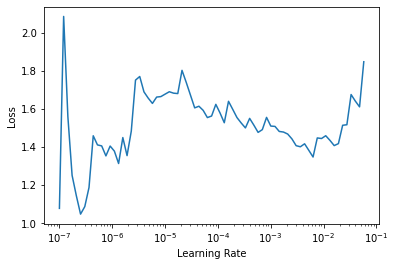

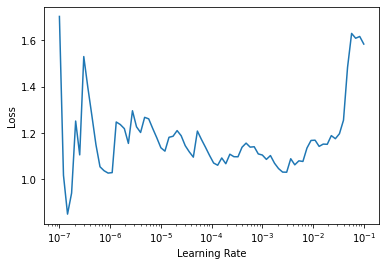

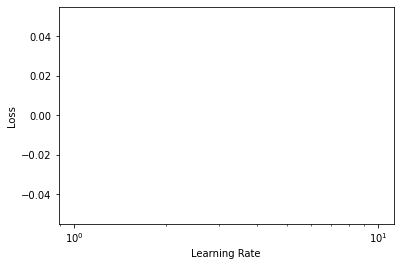

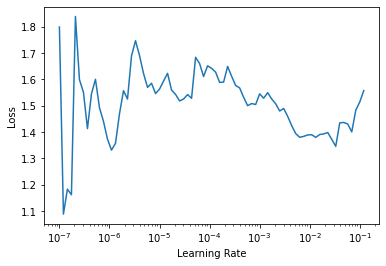

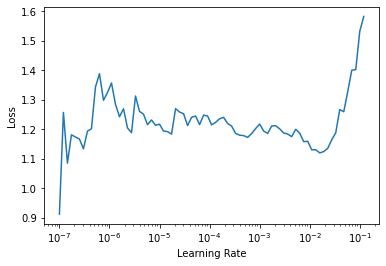

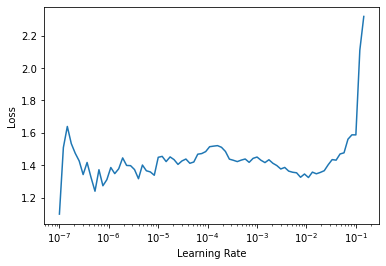

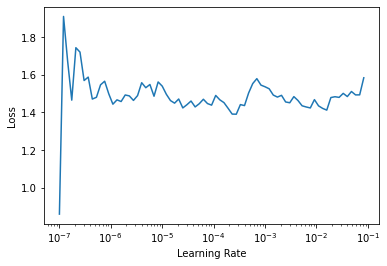

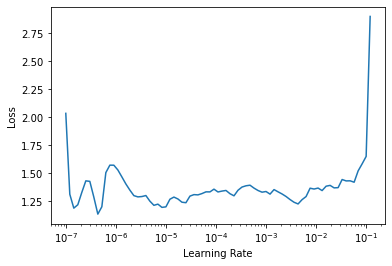

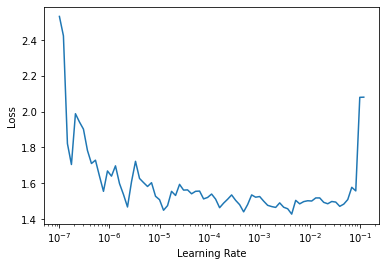

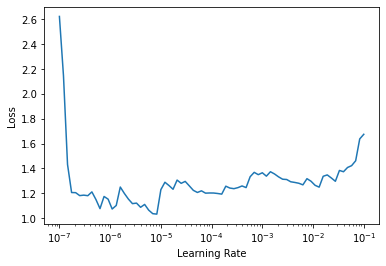

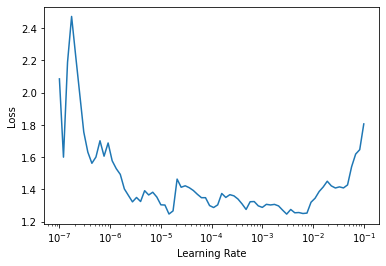

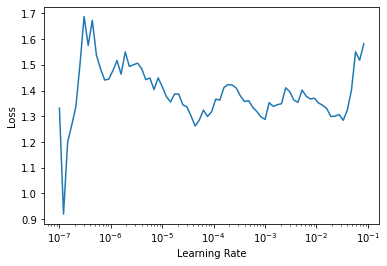

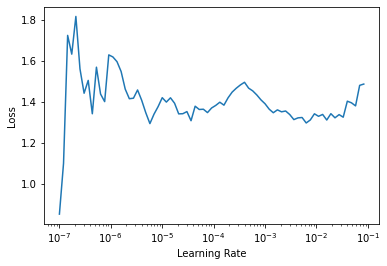

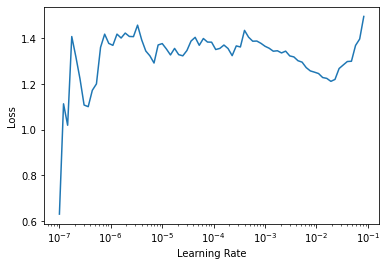

In [11]:
learns = {}
normalizations = {}

for Bravais, group in groups:
    dep_vars = PRED_COLS[Bravais]
    
    print(f"Training a model on {Bravais} subset")
    group = group.reset_index(drop=True)
    group = group.copy()
    # remove large unit cell by this line
    # group = group.sort_values(by='v', ascending=False).iloc[int(len(group)*.1):]
    group = group.sample(frac=1)
    group.reset_index(drop=True, inplace=True)    
    group[dep_vars] = np.log(group[dep_vars])

    mean = np.mean(group[dep_vars].values, axis=0)
    std = np.std(group[dep_vars].values, axis=0)

    normalizations[Bravais] = dict(mean=mean, std=std)
    group[dep_vars] = (group[dep_vars] - mean) / std
    
    learn = initializer(group, dep_vars, cont_names=list(df_predictors.columns[10:]), p=0.1)
    suggestions = learn.lr_find(suggestions=True)
    print(suggestions)
    
    lr_max=1e-2
    learn.fit_one_cycle(10, lr_max=lr_max)
    learn.fit_one_cycle(10, lr_max=lr_max)
    
    learn.export(lattice_folder/f"{Bravais}.pkl")
    
    learns[Bravais] = learn

In [12]:
import pickle

with (lattice_folder / LATTICE_NORM).open("wb") as f:
    pickle.dump(normalizations, f)